In [1]:
import pandas as pd
import csv
import nltk
import pickle
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectPercentile, f_classif
import keras
import tensorflow as tf
from keras import Input
from keras import optimizers
from keras import backend as K
import torch
from keras import regularizers
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import make_blobs
from keras.models import Sequential
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D 
from keras.utils import plot_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from itertools import chain
import seaborn as sns
from matplotlib import rcParams

In [2]:
#OPEN DATA from pickle files
#x_train, x_test, y_train, y_test

with open('x_train.pkl', 'rb') as file:
    x_train = pickle.load(file)
    
with open('x_test.pkl', 'rb') as file:
    x_test = pickle.load(file)

with open('y_train.pkl', 'rb') as file:
    y_train = pickle.load(file)
    
with open('y_test.pkl', 'rb') as file:
    y_test = pickle.load(file)
    
with open('tweet_collection.pkl', 'rb') as file:
    tweet_collection = pickle.load(file)

In [3]:
print(len(x_train))

6912


In [4]:
#Convert Labels from Strings to categorical Integers {Non-Hate = 1, Hate = 0}

df_ytrain = pd.DataFrame(y_train, columns = ['Label'])
df_ytest = pd.DataFrame(y_test, columns = ['Label'])

#flatten training set for fitting on tfidf
x_train_fit = list(chain.from_iterable(x_train))

mapping = {'Positive': 0, 'Negative': 1, 'Neutral':2}
df_ytrain = df_ytrain.replace({'Label': mapping})
df_ytest = df_ytest.replace({'Label': mapping})


train_y = df_ytrain['Label'].tolist()
test_y = df_ytest['Label'].tolist()

np_train_y = np.asarray(train_y)
np_test_y = np.asarray(test_y)

In [5]:
#Testing Encoding and Actual Values
for i in range(10):
    print("Sentence\n: "," ".join(str(item) for item in x_test[i]),"\n","True Value: ", y_test[i], "\nConverted: ",test_y[i],"\n~~~~~~~~~~~\n",sep="")

Sentence
: bbmsara win rin inday sara win
True Value: Positive
Converted: 0
~~~~~~~~~~~

Sentence
: inaniyo pag di si nanalo itatakwil pamilya
True Value: Negative
Converted: 1
~~~~~~~~~~~

Sentence
: presidential aspirant manila fired shots fellow aspirant vice president even using term yellowtards
True Value: Negative
Converted: 1
~~~~~~~~~~~

Sentence
: gobyernong tapat angat buhay si yancy iskolar bayan nakiki-isa pagsuporta kay vice president senator kiko pangilinan kasama tropa senatorial slate bayan matagal nating pinapangarap
True Value: Positive
Converted: 0
~~~~~~~~~~~

Sentence
: oras kandidatong tunay magdadala pagbabago nauuhaw lipunan si jade pahayagang forward kay kiko pangilinan
True Value: Positive
Converted: 0
~~~~~~~~~~~

Sentence
: ganyan nalang kontra sasabihin bbm kase wala yung amo kakambing imagine answer question halatang di kayang sagutin
True Value: Negative
Converted: 1
~~~~~~~~~~~

Sentence
: dictator ferdinand leading polls become next president philippine

In [6]:
#TFIDF, classifer building using the training dataset of tweets using a maximum features of the top 40%

def dummy_fun(doc):
    return doc

tfidf = TfidfVectorizer(
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None)  

#classifier building/ fitting of training dataset to tfidf
fitted_training_x = tfidf.fit_transform(x_train)
fitted_testing_x = tfidf.transform(x_test)

#transform based on top 40 percent features
selector = SelectPercentile(f_classif, percentile = 40)
selector.fit(fitted_training_x, train_y)

SelectPercentile(percentile=40)

In [7]:
#Convert tweet tokens into vectors using the classifier built using tfidf


x_train_vectorized = selector.transform(fitted_training_x).toarray()
x_test_vectorized = selector.transform(fitted_testing_x).toarray()

number_of_features = len(x_train_vectorized[0])

In [8]:
#FFNN MODEL
print("training CNN ...")

#create model
model = Sequential()
model.add(Input(shape=(number_of_features,), name='Input-Layer'))
model.add(Dense(1000, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(500, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(50, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

#optimizer using the default values
adam = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

#compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

training CNN ...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1000)              6048000   
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 dense_1 (Dense)             (None, 500)               500500    
                                                                 
 dropout_1 (Dropout)         (None, 500)               0         
                                                                 
 dense_2 (Dense)             (None, 50)                25050     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 3) 

In [9]:
#fit dataset and model
##### Step 5 - Fit keras model on the dataset
model_history = model.fit(x_train_vectorized, # input data
          np_train_y, # target data
          epochs=5, # default=1, Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided
          verbose='auto', # default='auto', ('auto', 0, 1, or 2). Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch. 'auto' defaults to 1 for most cases, but 2 when used with ParameterServerStrategy.
          validation_split = 0.1
         )

model.save('cabasag_model.h5')

Epoch 1/5
195/195 [==============================] - 5s 25ms/step - loss: 0.8977 - accuracy: 0.5605 - val_loss: 0.6886 - val_accuracy: 0.6980
Epoch 2/5
195/195 [==============================] - 4s 23ms/step - loss: 0.5582 - accuracy: 0.7772 - val_loss: 0.6623 - val_accuracy: 0.7153
Epoch 3/5
195/195 [==============================] - 5s 23ms/step - loss: 0.3587 - accuracy: 0.8619 - val_loss: 0.7255 - val_accuracy: 0.7298
Epoch 4/5
195/195 [==============================] - 4s 23ms/step - loss: 0.2573 - accuracy: 0.9053 - val_loss: 0.7908 - val_accuracy: 0.7168
Epoch 5/5
195/195 [==============================] - 5s 23ms/step - loss: 0.1956 - accuracy: 0.9223 - val_loss: 0.9034 - val_accuracy: 0.7124


In [10]:
#test for accuracies

results_training = model.evaluate(x_train_vectorized, np_train_y)
print(results_training)

216/216 [==============================] - 1s 5ms/step - loss: 0.2116 - accuracy: 0.9190
[0.21163836121559143, 0.9189814925193787]


In [11]:
#test for accuracies

results_testing = model.evaluate(x_test_vectorized, np_test_y)
print(results_testing)

24/24 [==============================] - 0s 5ms/step - loss: 1.4009 - accuracy: 0.6302
[1.4009288549423218, 0.6302083134651184]


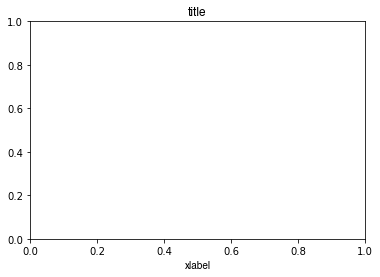

In [12]:
#plot configuration
CB91_Blue = '#2CBDFE'
CB91_Green = '#47DBCD'
CB91_Pink = '#F3A0F2'
CB91_Purple = '#9D2EC5'
CB91_Violet = '#661D98'
CB91_Amber = '#F5B14C'

color_list = [CB91_Blue, CB91_Amber]

csfont = {'fontname':'Helvetica'}
hfont = {'fontname':'Helvetica'}

plt.title('title',**csfont)
plt.xlabel('xlabel', **hfont)
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)

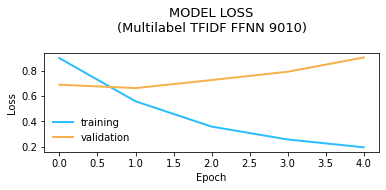

In [13]:
# plot loss during training
plt.subplot(212)
plt.title('MODEL LOSS\n(Multilabel TFIDF FFNN 9010)\n', fontsize = 13)
plt.plot(model_history.history['loss'], label='training', linewidth=2)
plt.plot(model_history.history['val_loss'], label='validation', linewidth=2)
plt.legend(frameon=False)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

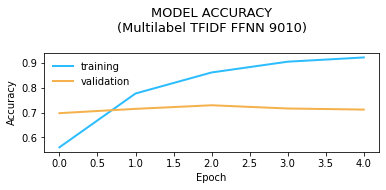

In [14]:
# plot accuracy during training
plt.subplot(212)
plt.title('MODEL ACCURACY\n(Multilabel TFIDF FFNN 9010)\n', fontsize = 13)
plt.plot(model_history.history['accuracy'], label='training', linewidth=2)
plt.plot(model_history.history['val_accuracy'], label='validation', linewidth=2)
plt.legend(frameon=False)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [15]:
#use predictions on test data
##### Step 6 - Use model to make predictions
# Predict class labels on training data
pred_labels_train = model.predict(x_train_vectorized)
# Predict class labels on a test data
pred_labels_test = model.predict(x_test_vectorized)

#print(pred_labels_train)
pred_labels_train_1 = []

pred_labels_test_1 = []

pred_labels_test_y = []


for i in range(len(pred_labels_train)):
    label = np.argmax(pred_labels_train[i])
    pred_labels_train_1.append(label)
    
for i in range(len(pred_labels_test)):
    label = np.argmax(pred_labels_test[i]) 
    pred_labels_test_1.append(label)
    pred_labels_test_y.append(pred_labels_test[i][label])

##### Step 7 - Model Performance Summary
print("")
print('-------------------- Model Summary --------------------\n')
model.summary() # print model summary
print("")
print('\n---------- Evaluation on Training Data ----------')
print(classification_report(np_train_y, pred_labels_train_1, digits = 4))
print("")

print('\n---------- Evaluation on Test Data ----------')
print(classification_report(np_test_y, pred_labels_test_1, digits = 4))
print("")

24/24 [==============================] - 0s 5ms/step

-------------------- Model Summary --------------------

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1000)              6048000   
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 dense_1 (Dense)             (None, 500)               500500    
                                                                 
 dropout_1 (Dropout)         (None, 500)               0         
                                                                 
 dense_2 (Dense)             (None, 50)                25050     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
           

[[187  19  38]
 [ 38 170  33]
 [118  38 127]]


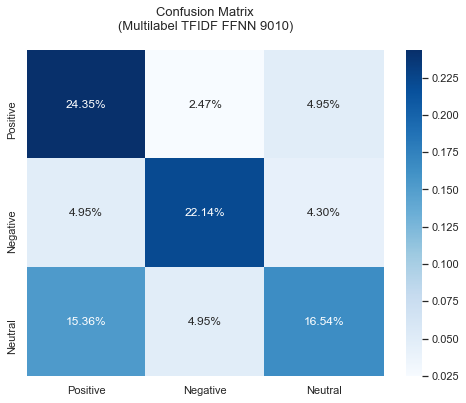

In [16]:
cf_matrix = confusion_matrix(np_test_y, pred_labels_test_1)
print(cf_matrix)

sns.set(rc={"figure.figsize":(8, 6)})
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, xticklabels = ['Positive', 'Negative', 'Neutral'], yticklabels = ['Positive', 'Negative', 'Neutral'],
            fmt='.2%', cmap='Blues')

plt.title('Confusion Matrix\n(Multilabel TFIDF FFNN 9010)\n', fontsize = 13)
plt.show()

In [17]:
test_results = pd.DataFrame(list(zip(x_test,pred_labels_test_1, pred_labels_test_y)), columns = ['Tweet','Prediction', 'Prediction Value'])
test_results 

,Tweet,Prediction,Prediction Value
0,"[bbmsara, win, rin, inday, sara, win]",0,0.891507
1,"[inaniyo, pag, di, si, nanalo, itatakwil, pami...",0,0.991369
2,"[presidential, aspirant, manila, fired, shots,...",1,0.763399
3,"[gobyernong, tapat, angat, buhay, si, yancy, i...",0,0.998858
4,"[oras, kandidatong, tunay, magdadala, pagbabag...",0,0.969080
...,...,...,...
763,"[presidente, bise, presidente, kiko, pangilina...",0,0.998056
764,"[mt, mayon, showed, seems, like, looking, vp, ...",0,0.564144
765,[president],2,0.534855
766,"[unforgettable, rally, experience, agusan, del...",2,0.940731


In [18]:
#Saving labels to be used on other files
true_labels = open('true_labels.pkl', 'wb')
pickle.dump(np_test_y,true_labels)
true_labels.close()

predicted_labels = open('TFIDFFFNN_predicted_labels.pkl', 'wb')
pickle.dump(pred_labels_test_1,predicted_labels)
predicted_labels.close()

TFIDFFFNN_test_results = open('TFIDFFFNN_test_results.pkl', 'wb')
pickle.dump(test_results,TFIDFFFNN_test_results)
TFIDFFFNN_test_results.close()

In [18]:
#test_predictions = (model.predict(x_test_vectorized) > 0.5).astype(int)

#test_prediction_labels = []

#for i in range(len(test_predictions)):
    
#    trueval = 'Positive'
    
#    if(test_predictions[i][1] == 1):
 #       pred = 'Negative'
    
#    if(test_predictions[i][2] == 1):
#        pred = 'Neutral'
    
#    test_prediction_labels.append(pred)
#    print("Sentence\n: "," ".join(str(item) for item in x_test[i]),"\n","True Value: ", trueval, "\nPred: ",pred, "\n~~~~~~~~~~~\n",sep="")

In [19]:
#comparison_dataframe = pd.DataFrame(list(zip(x_test,y_test, test_prediction_labels)), columns = ['Tweet','True Label', 'Clasiification Label'])  

#with pd.option_context('display.max_rows', None,
#                       'display.max_columns', None,
#                       'display.precision', 3,
#                       ):
#    display(comparison_dataframe)